# Process

1. 변수 생성
2. Target Encoder
3. MinMaxScaler + HistGradeintBoosting Model
4. Clipping

In [ ]:
!pip install optuna category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
#Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,OrdinalEncoder, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DATA

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Datasets/데이콘/HD/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Datasets/데이콘/HD/test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/Datasets/데이콘/HD/sample_submission.csv")

train.drop(['SAMPLE_ID'],1,inplace=True)
test.drop(['SAMPLE_ID'],1,inplace=True)

In [ ]:
import datetime
#ATA
def transform_time(df):
  df.drop(['ID','SHIPMANAGER','FLAG'],1, inplace=True)

  df['ATA'] = pd.to_datetime(df['ATA'])
  df['YEAR'] = df['ATA'].dt.year
  df['MONTH'] = df['ATA'].dt.month
  df['DAY'] = df['ATA'].dt.day
  df['HOUR'] = df['ATA'].dt.hour
  df['MINUTES'] = df['ATA'].dt.minute
  df['WOY'] = df['ATA'].dt.weekofyear
  df['WEEKDAY'] = df['ATA'].dt.weekday
  df['WEEKEND'] = df['WEEKDAY'].apply(lambda x: 1 if x >= 5 else 0)
  df['HOLIDAY'] = df['ATA'].apply(lambda x: 1 if (x.month == 1 and x.day == 1) or (x.month == 12 and x.day==25) else 0)

   #연령
  df['AGE'] = df['YEAR'] - df['BUILT']
  df['ship_volume'] = df['LENGTH'] * df['BREADTH'] * df['DEPTH']
  df['efficiency'] = df['DEADWEIGHT'] / df['GT']
  df['wind_magnitude'] = np.sqrt(df['U_WIND']**2 + df['V_WIND']**2)
  df['wind_direction'] = np.arctan2(df['V_WIND'], df['U_WIND'])
  df['relative_distance'] = df['DIST'] / df['PORT_SIZE']

  #
  df['wind_magnitude'] = df['wind_magnitude'].isna().astype(int)
  df['wind_direction'] = df['wind_direction'].isna().astype(int)

  df.drop(['ATA'],1,inplace=True)
  return df

train = transform_time(train)
test = transform_time(test)

train.drop(train[train['BREADTH'].isna()].index, 0, inplace=True)

In [ ]:
X = train.drop(['CI_HOUR'],1)
y = train['CI_HOUR']

cat_cols = X.select_dtypes(include='object').columns.tolist()
X.shape, test.shape

((391938, 32), (220491, 32))

In [ ]:
##categpry
from category_encoders.target_encoder import TargetEncoder
enc=TargetEncoder()
for col in cat_cols:
  X[col] = enc.fit_transform(X[col],y)
  test[col] = enc.transform(test[col])

In [ ]:
# enc = LabelEncoder()
# for col in cat_cols:
#   X[col] = enc.fit_transform(X[col])
#   test[col] = enc.transform(test[col])

In [ ]:
# from sklearn.feature_selection import SelectKBest, f_regression

# selector = SelectKBest(f_regression, k=20)
# X_new = selector.fit_transform(X,y)

# # 선택된 피쳐의 인덱스를 얻습니다.
# selected_indices = selector.get_support(indices=True)

# # 원래 데이터의 피쳐 이름을 사용하여 선택된 피쳐의 이름을 얻습니다.
# selected_feature_names = [X.columns[i] for i in selected_indices]

# selected_feature_names

# Model

In [ ]:
%%time
from sklearn.compose import make_column_selector, make_column_transformer

preprocessor = ColumnTransformer(
    transformers=[
        ('ss', MinMaxScaler(), X.columns),
    ], remainder='passthrough'
)
params = {'max_iter': 1969,
 'max_leaf_nodes': 96,
 'max_depth': 11,
 'min_samples_leaf': 43,
 'l2_regularization': 0.03503250404129518}

pipe = Pipeline(
    [
        ('MIN',preprocessor),
        ('HIST',HistGradientBoostingRegressor(random_state=42, loss='absolute_error', **params))
    ]
)

pipe.fit(X,y)

CPU times: user 55.2 s, sys: 372 ms, total: 55.6 s
Wall time: 32.6 s


Pipeline(steps=[('MIN',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', MinMaxScaler(),
                                                  Index(['ARI_CO', 'SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'DEADWEIGHT',
       'DEPTH', 'DRAUGHT', 'PORT_SIZE', 'YEAR', 'HOUR', 'WEEKDAY',
       'ship_volume', 'efficiency', 'relative_distance'],
      dtype='object'))])),
                ('HIST',
                 HistGradientBoostingRegressor(l2_regularization=0.03503250404129518,
                                               loss='absolute_error',
                                               max_depth=11, max_iter=1969,
                                               max_leaf_nodes=96,
                                               min_samples_leaf=43,
                                               random_state=42))])

In [ ]:
%%time
fold = KFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(estimator=pipe, X=X, y=y, cv=fold, scoring='neg_mean_absolute_error')
print(np.round(-score,2))
print()
print(f"5 K-FOLD : {np.round(np.mean(-score),2)} & std +/-{np.round(np.std(-score),2)}")

[43.71 44.97 44.83 43.72 43.89]

5 K-FOLD : 44.22 & std +/-0.56
CPU times: user 3min 1s, sys: 1.26 s, total: 3min 2s
Wall time: 1min 48s


#OPTUNA

In [ ]:
def objective(trial, data=X, target=y):
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2, random_state=42)
  param = {
      'max_iter':trial.suggest_int('max_iter', 1500, 2500),
      'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',80, 200),
      'max_depth':trial.suggest_int('max_depth', 10, 15),
      'min_samples_leaf':trial.suggest_int('min_samples_leaf',35,45),
      'l2_regularization':trial.suggest_float('l2_regularization',0.05, 0.1)
  }

  model = HistGradientBoostingRegressor(random_state=42, loss='absolute_error', **param)

  model.fit(X_train, y_train)

  preds = model.predict(X_test)

  mae = mean_absolute_error(y_test, preds)

  return mae

In [ ]:
#preceed
study.optimize(objective, n_trials=30)

[I 2023-10-23 04:30:27,108] Trial 10 finished with value: 44.041397914560875 and parameters: {'max_iter': 996, 'max_leaf_nodes': 86, 'max_depth': 18, 'min_samples_leaf': 34, 'l2_regularization': 0.0011613500790203374}. Best is trial 2 with value: 43.933498504153484.
[I 2023-10-23 04:30:47,106] Trial 11 finished with value: 44.10238787608084 and parameters: {'max_iter': 983, 'max_leaf_nodes': 99, 'max_depth': 20, 'min_samples_leaf': 34, 'l2_regularization': 0.0012633671670008785}. Best is trial 2 with value: 43.933498504153484.
[I 2023-10-23 04:31:11,473] Trial 12 finished with value: 44.10461335695287 and parameters: {'max_iter': 512, 'max_leaf_nodes': 84, 'max_depth': 16, 'min_samples_leaf': 31, 'l2_regularization': 0.0015694078491966259}. Best is trial 2 with value: 43.933498504153484.
[I 2023-10-23 04:31:30,829] Trial 13 finished with value: 44.14274420647564 and parameters: {'max_iter': 1037, 'max_leaf_nodes': 82, 'max_depth': 17, 'min_samples_leaf': 40, 'l2_regularization': 0.0271

In [ ]:
study.best_params

{'max_iter': 1969,
 'max_leaf_nodes': 96,
 'max_depth': 11,
 'min_samples_leaf': 43,
 'l2_regularization': 0.03503250404129518}

In [ ]:
import joblib
study = joblib.load('/content/drive/MyDrive/Datasets/데이콘/HD/hist.pkl')

In [ ]:
study.optimize(objective, n_trials=30)

[I 2023-10-23 11:45:34,428] Trial 40 finished with value: 43.9308936388535 and parameters: {'max_iter': 1793, 'max_leaf_nodes': 97, 'max_depth': 15, 'min_samples_leaf': 41, 'l2_regularization': 0.0509768136746344}. Best is trial 35 with value: 43.815621078059905.
[I 2023-10-23 11:45:55,278] Trial 41 finished with value: 43.963925935290135 and parameters: {'max_iter': 1908, 'max_leaf_nodes': 97, 'max_depth': 11, 'min_samples_leaf': 38, 'l2_regularization': 0.04311922048385841}. Best is trial 35 with value: 43.815621078059905.
[I 2023-10-23 11:46:41,218] Trial 42 finished with value: 43.78832803212892 and parameters: {'max_iter': 1914, 'max_leaf_nodes': 87, 'max_depth': 14, 'min_samples_leaf': 42, 'l2_regularization': 0.037392091444611274}. Best is trial 42 with value: 43.78832803212892.
[I 2023-10-23 11:46:59,453] Trial 43 finished with value: 44.114564096477665 and parameters: {'max_iter': 1908, 'max_leaf_nodes': 86, 'max_depth': 14, 'min_samples_leaf': 42, 'l2_regularization': 0.04618

In [ ]:
from optuna.visualization import *

plot_slice(study)

In [ ]:
plot_param_importances(study)

# Predictions

In [ ]:
X.shape, test[X.columns].shape

((391939, 27), (220491, 27))

In [ ]:
prediction = pipe.predict(test[X.columns]).clip(0,)

sample_submission['CI_HOUR'] = prediction

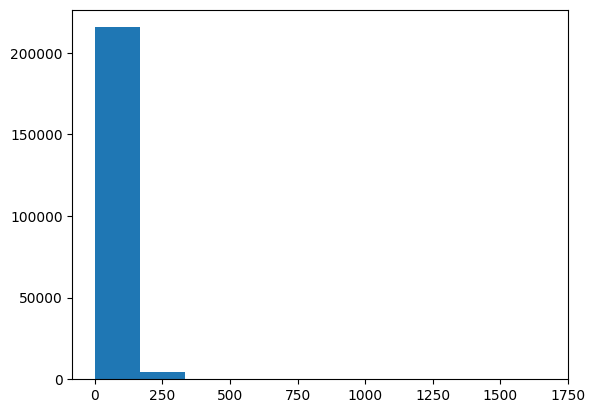

In [ ]:
plt.hist(prediction)
plt.show()

In [ ]:
sample_submission.to_csv("./change_to_zero_dist_targetencoding.csv", index=False)

In [ ]:
sample_submission

,SAMPLE_ID,CI_HOUR
0,TEST_000000,7.431300e-01
1,TEST_000001,2.243379e+01
2,TEST_000002,2.641960e+01
3,TEST_000003,7.823996e+01
4,TEST_000004,4.889251e-18
...,...,...
220486,TEST_220486,9.991526e+01
220487,TEST_220487,6.269333e+01
220488,TEST_220488,2.695241e+01
220489,TEST_220489,4.889251e-18
